In [1]:
import torch

Will build a NN for CIFAR-10, which consists of 32x32 RGB images labeled with 1 of 10 classes.

In [2]:
from torchvision import datasets
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True) # will download if not found
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


Dataset returned as a subclass of ```torch.utils.data.Dataset```.

In [3]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

```Dataset``` objects implement ```__len__```, the number of items in the dataset, and ```__getitem__```, a sample and its corresponding label. So, it can use the len methods and regular Python indexing. It provides uniform access to the data, though it doesn't necessarily hold it.

In [4]:
len(cifar10)

50000

In [5]:
img, label = cifar10[99]
img, label

(<PIL.Image.Image image mode=RGB size=32x32>, 1)

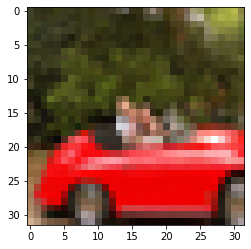

In [6]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

Need to convert PIL image to PyTorch Tensor.

In [7]:
from torchvision import transforms
dir(transforms)

['AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [8]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape # C x H x W as expected

torch.Size([3, 32, 32])

Could be applied directly on dataset.

In [9]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

In [10]:
img_t, _ = tensor_cifar10[99]
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

Scaled from 0-1

In [11]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

Verify we're getting the same img.

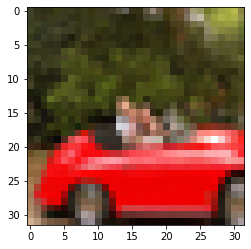

In [12]:
plt.imshow(img_t.permute(1, 2, 0)) # change the order to H x W x C so plt can display it
plt.show()

Normalize data

In [13]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [14]:
imgs.view(3, -1).mean(dim=1) # keeps 3 channels and merges all remaining dims into one--recall -1 means size is inferred from other dims

tensor([0.4914, 0.4822, 0.4465])

In [15]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [16]:
transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])

Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])

In [17]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([transforms.ToTensor(), 
                                  transforms.Normalize([0.4914, 0.4822, 0.4465], 
                                                       [0.2470, 0.2435, 0.2616])
                                 ]))
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([transforms.ToTensor(), 
                                  transforms.Normalize([0.4914, 0.4822, 0.4465], 
                                                       [0.2470, 0.2435, 0.2616])
                                 ]))

Can plot image drawn from normalized dataset, but will look weird as pixel values outside of 0.0-1.0 range and magnitudes are changed.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


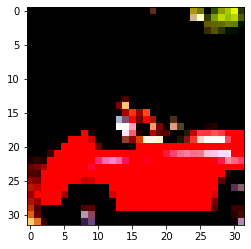

In [18]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

## Telling birds from planes


Filter dataset to only keep birds and airplanes. We're not creating a ```Dataset``` but may want to do in the future.

In [19]:
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird'] # so 0 is airplane, 1 is bird
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]

Create a basic NN--take input as flattened vector of the images.

In [20]:
import torch.nn as nn
n_out = 2
model = nn.Sequential(nn.Linear(3072, 512,), #3072 is 3*32*32; arbitrarily pick 512 hidden features
                      nn.Tanh(),
                      nn.Linear(512, n_out,)) # n_out is 2 because there are 2 possible classifications

Output is categorical--interpret output of NN in terms of probabilities. Use Softmax.

In [21]:
softmax = nn.Softmax(dim=1) # operate along columns
x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [22]:
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, n_out),
                      nn.Softmax(dim=1))

Try to run model before training.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


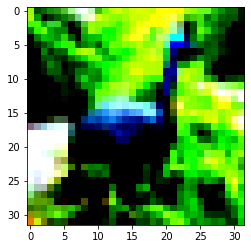

In [23]:
img, _ = cifar2[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()

Change dimensions of img to work with NN.

In [24]:
img_batch = img.view(-1).unsqueeze(0)
img_batch.shape

torch.Size([1, 3072])

In [25]:
out = model(img_batch)
out

tensor([[0.5540, 0.4460]], grad_fn=<SoftmaxBackward0>)

Right now, we don't know if the first or second element of the output corresponds to bird or airplane. This will come with training and the loss function. Find the index of the max element to find the label.

In [26]:
_, index = torch.max(out, dim=1)
index

tensor([0])

So, we classified the img as an airplane. Now, need to find a **loss function**. Want to maximize probability associated with the correct class. So, we want a loss function that is very high when the likelihood is low and vice-versa. We will use negative log likelihood (NLL). $$\text{NLL} = -\sum_{i=1}^{N}(\log{out_{i}[c_{i}]})$$ where sum is taken over $N$ classes and $c_{i}$ is the correct class for sample i.

PyTorch has an ```nn.NLLLoss``` class that takes log probabilities as input. We will use ```nn.LogSoftmax``` because logarithms of probabilities get weird around 0.

In [27]:
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, n_out),
                      nn.LogSoftmax(dim=1))
loss = nn.NLLLoss()

Test loss function.

In [28]:
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
out, torch.tensor([label])

(tensor([[-0.8437, -0.5624]], grad_fn=<LogSoftmaxBackward0>), tensor([1]))

In [29]:
loss(out, torch.tensor([label])) # takes the output of nn.LogSoftmax for a batch as 1st arg, label as a tensor for the 2nd

tensor(0.5624, grad_fn=<NllLossBackward0>)

Note that using cross-entropy error is better for classification output as slope of MSE too small to compensate for flatness of Softmax function for wrong predictions.

### Train the Classifier

In [43]:
import torch.optim as optim

In [ ]:
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

def training_loop(n_epochs, optimizer, loss_fn, learning_rate, dataset):
    for epoch in range(1, n_epochs + 1):
        for img, label in dataset: # only does one image at a time -- so using minibatches of size 1
            out = model(img.view(-1).unsqueeze(0))
            loss = loss_fn(out, torch.tensor([label]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch - 1) % 10 == 0:
            print(f"Epoch: {epoch}, Loss: {float(loss)}") # prints loss for last image
training_loop(n_epochs, optimizer, loss_fn, learning_rate, cifar2)

The above is taking a while to run. Try splitting code into minibatches using ```DataLoader```

In [44]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True) # note: can be iterated over

In [45]:
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(1, n_epochs + 1):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0] # imgs is 64 x 3 x 32 x 32
        outputs = model(imgs.view(batch_size, -1)) # 64 x 3072 so can be used in model
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {float(loss)}") # prints loss for last batch

Epoch: 1, Loss: 0.30592626333236694
Epoch: 10, Loss: 0.3994148373603821
Epoch: 20, Loss: 0.1631508618593216
Epoch: 30, Loss: 0.256850928068161
Epoch: 40, Loss: 0.14552552998065948
Epoch: 50, Loss: 0.05469111353158951
Epoch: 60, Loss: 0.039953336119651794
Epoch: 70, Loss: 0.024343909695744514
Epoch: 80, Loss: 0.042266637086868286
Epoch: 90, Loss: 0.009794686920940876
Epoch: 100, Loss: 0.021155288442969322


Compute validation accuracy.

In [46]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
correct = 0
total = 0

with torch.no_grad(): # don't change gradient as doing validation
    for imgs, labels in val_loader: # labels has 64 classifications, 1 for each img. Each img has 2 outputs corresp to probs
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1) 
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print(f"Accuracy: {correct/total}")

Accuracy: 0.8115


Note that using LogSoftmax and NLLLoss is equivalent to using CrossEntropyLoss in ```torch.nn```.

In [47]:
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, n_out))
loss_fn = nn.CrossEntropyLoss()

In [48]:
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 100

for epoch in range(1, n_epochs + 1):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0] # imgs is 64 x 3 x 32 x 32
        outputs = model(imgs.view(batch_size, -1)) # input is 64 x 3072 so can be used in model         
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {float(loss)}") # prints loss for last batch

Epoch: 1, Loss: 0.691723644733429
Epoch: 10, Loss: 0.2858087122440338
Epoch: 20, Loss: 0.39452600479125977
Epoch: 30, Loss: 0.1260950118303299
Epoch: 40, Loss: 0.06228930503129959
Epoch: 50, Loss: 0.08405914157629013
Epoch: 60, Loss: 0.0559680312871933
Epoch: 70, Loss: 0.03783710300922394
Epoch: 80, Loss: 0.009257925674319267
Epoch: 90, Loss: 0.018259191885590553
Epoch: 100, Loss: 0.016168838366866112


Find the number of trainable parameters.

In [49]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
numel_list

[1572864, 512, 1024, 2]

This is a lot of parameters--and we need it if we keep our input as a vector, as it will scale as the number of pixels increases.

Note that using a 1D view of the image takes every single input value and computes a linear combination of it with all other features for every output feature. It also doesn't use the relative position of neighboring or far-away pixels. Thus a fully-trained network is not translation-invariant. This is likely why we end up overfitting. Use convolutions to do better.

Note: need to save cifar2 to use in next chapter.

In [31]:
import pickle
# pickle.dump(cifar2, open("cifar2.p", "wb"))
# pickle.dump(cifar2_val, open("cifar2_val.p", "wb"))

## Exercises